In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocab of characters and mapping to and from the integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{0: '.', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}


In [48]:
# building the dataset

block_size = 3
X, Y = [], []

for w in words[:5]:

    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]  # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
olivia
ava
isabella
sophia


In [49]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [50]:
C = torch.randn((27, 2))  # embedding layer

In [51]:
emb = C[X]
print(emb.shape)

torch.Size([32, 3, 2])


In [52]:
# F.one_hot(torch.tensor(5), num_classes=27).float() @ C

In [53]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [54]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
print(h.shape)

torch.Size([32, 100])


In [55]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [56]:
logits = h @ W2 + b2
print(logits.shape)

counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
print('Every row of prob sums to', prob[0].sum().item())

loss = -prob[torch.arange(32), Y].log().mean()
print(loss.item())

torch.Size([32, 27])
Every row of prob sums to 1.0
18.22321128845215


### Now all at once, properly

In [253]:
# building the dataset

def build_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:

        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [279]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [280]:
print('Total number of parameters:', sum(p.nelement() for p in parameters))

Total number of parameters: 11897


- F.cross_entropy() makes the forward and backward pass much more efficient, as all the intermediate tensors are not created and stored in memory. 
- makes calculating the derivative mathematically better. 
- solves the issue with large logits, which can cause the exponential to overflow.

In [281]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
lossi = []
stepi = []

In [286]:
for i in range(200000):

    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]]  # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # # stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())

print('Loss:', loss.item())

Loss: 2.2229881286621094


In [287]:
emb = C[Xtr]  # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print('Train Loss:', loss.item())

emb = C[Xdev]  # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print('Dev Loss:', loss.item())

emb = C[X]  # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Y)
print('Full Loss:', loss.item())

Train Loss: 2.068772315979004
Dev Loss: 2.109295606613159
Full Loss: 2.0779480934143066


In [310]:
# sample from the model
g = torch.Generator().manual_seed(42)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, dimension)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim=1)
        ix = torch.multinomial(prob, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    
    print(''.join(itos[i] for i in out))

z

terin

chriem
cleig
ni
ker
jezere
dixo
fol
emir
k

fricl
k
t
re




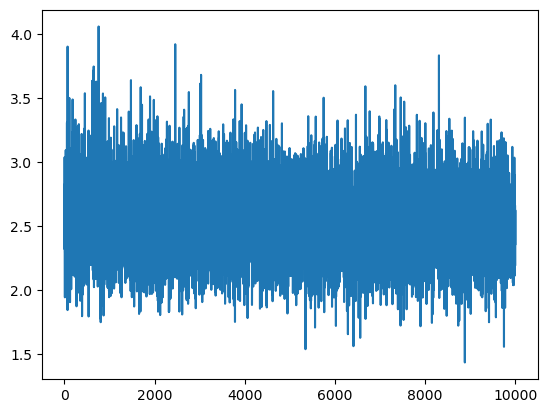

In [270]:
plt.plot(stepi, lossi)